In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
import math
import itertools
from IPython.display import clear_output
import numpy as np

%matplotlib inline 
#plt.set_cmap(cm.get_cmap("Spectral_r"))

Transposing cartesian coordinates to latitude / longitude 

https://math.stackexchange.com/questions/296794/finding-the-transform-matrix-from-4-projected-points-with-javascript/339033#339033


| var | cartesian | GPS |
|-----|-----------|-------------------------|
| x1  | (0,0)     | (40.750885, -73.998169) |
| x2  | (0,28)    | (40.768575, -73.985212) |
| x3  | (10,0)    | (40.743195, -73.979931) |
| x4  | (10,28)   | (40.760918, -73.966995) |


Below are just helpful calculations for getting the final combined matrix that transforms from source to destination

In [ ]:
xC1 = (0,0)
xC2 = (0,28)
xC3 = (10,0)
xC4 = (10,28)

xLL1 = (40.750885, -73.998169)
xLL2 = (40.768575, -73.985212)
xLL3 = (40.743195, -73.979931)
xLL4 = (40.760918, -73.966995)

m_AC = np.mat([[xC1[0], xC2[0], xC3[0]], [xC1[1], xC2[1], xC3[1]], [1, 1, 1]])
m_BC = np.array(list(xC4) + [1]).reshape(-1,1)
lambda_C = np.matmul(np.linalg.inv(m_AC), m_BC)
lambda_C_ext = np.repeat(np.transpose(lambda_C), repeats=3,axis=0)
transform_C =  np.multiply(lambda_C_ext, m_AC)

m_ALL = np.mat([[xLL1[0], xLL2[0], xLL3[0]], [xLL1[1], xLL2[1], xLL3[1]], [1, 1, 1]])
m_BLL = np.array(list(xLL4) + [1]).reshape(-1,1)
lambda_LL = np.matmul(np.linalg.inv(m_ALL), m_BLL)
lambda_LL_ext = np.repeat(np.transpose(lambda_LL), repeats=3,axis=0)
transform_LL =  np.multiply(lambda_LL_ext, m_ALL)

fullmap = transform_LL * np.linalg.inv(transform_C)

def get_gps_coords(x, y):
    m_coords = np.transpose(np.mat([x, y, 1]))
    m_output = np.matmul(fullmap, m_coords)
    lat = np.around(m_output[0,0] / m_output[2,0], decimals=6)
    long = np.around(m_output[1,0] / m_output[2,0], decimals=6)
    return (lat, long)

#TEST
tests = [get_gps_coords(*xC1) == xLL1,
get_gps_coords(*xC2) == xLL2,
get_gps_coords(*xC3) == xLL3,
get_gps_coords(*xC4) == xLL4]

print(all(tests))

In [ ]:
cart_Xs = [0, 2, 4, 6, 7, 8, 9, 10]
name_Xs = dict(zip(cart_Xs, ["9","8","7","6","5","Madison","Park","Lexington","3"]))
cart_Ys = list(range(0,29))
name_Ys = dict(zip(cart_Ys, [str(i+30) for i in cart_Ys]))

In [ ]:
DG = nx.DiGraph()
coords = list(itertools.product(cart_Xs,cart_Ys))
for nodeid, pair in enumerate(coords):
    intersection = name_Xs[pair[0]] + "_" +  name_Ys[pair[1]]
    gps = get_gps_coords(*pair)
    DG.add_node(nodeid, cartesian=pair, name = intersection, latitude = gps[0], longitude = gps[1], nodetype="inner", color="#e1e3f0", volume_rate=dict())

nodes = {v: k for k, v in nx.get_node_attributes(DG, "cartesian").items()}

for pair in nodes:
    
    nextave = cart_Xs.index(pair[0])+1
    if nextave >= len(cart_Xs):
        right = (-1,-1)
    else:
        right = (cart_Xs[nextave] , pair[1])
    above = (pair[0], pair[1] + 1)

    eastboundst = (pair[1] % 2) == 0   
    
    if above in nodes:#  and pair[0] not in {1,6}:
        
        if pair[0] in [2, 6, 8, 10]:
            DG.add_edge(nodes[pair], nodes[above], direction='north', lanes = 4, name = name_Xs[pair[0]] + "_ave")
        elif pair[0] == 9:
            DG.add_edge(nodes[pair], nodes[above], direction='north', lanes = 2, name = name_Xs[pair[0]] + "_ave")
            DG.add_edge(nodes[above], nodes[pair], direction='south', lanes = 2, name = name_Xs[pair[0]] + "_ave")
        else:
            DG.add_edge(nodes[above], nodes[pair], direction='south', lanes = 4, name = name_Xs[pair[0]] + "_ave")
            
    if right in nodes: # and pair[1] not in {1,6}:
        if pair[1] in [4, 12, 27]:
            DG.add_edge(nodes[pair], nodes[right], direction='east', lanes = 2, name = name_Ys[pair[1]] + "_st")
            DG.add_edge(nodes[right], nodes[pair], direction='west', lanes = 2, name = name_Ys[pair[1]] + "_st")
        if eastboundst:
            DG.add_edge(nodes[pair], nodes[right], direction='east', lanes = 2, name = name_Ys[pair[1]] + "_st")
        else:
            DG.add_edge(nodes[right], nodes[pair], direction='west', lanes = 2, name = name_Ys[pair[1]] + "_st")
            

for node in DG.nodes:
    border_west = DG.nodes[node]["cartesian"][0] == 0
    border_east = DG.nodes[node]["cartesian"][0] == 10
    
    border_north = DG.nodes[node]["cartesian"][1] == 0
    border_south = DG.nodes[node]["cartesian"][1] == 28
    
    border = (border_west or border_east or border_north or border_south)
    
    if DG.nodes[node]["cartesian"][0] == 0: # west border
        if DG.nodes[node]["cartesian"][1] in [4, 12, 27]:
            DG.nodes[node]["nodetype"] = "source_sink"
            DG.nodes[node]["color"] = "yellow"
        elif len([i for i in DG.out_edges(node) if DG.edges[i]['direction'] == 'east']) > 0:
            DG.nodes[node]["nodetype"] = "source"
            DG.nodes[node]["color"] = "green"
        else:
            DG.nodes[node]["nodetype"] = "sink"
            DG.nodes[node]["color"] = "red"
    elif DG.nodes[node]["cartesian"][0] == 10: # east border
        if DG.nodes[node]["cartesian"][1] in [4, 12, 27]:
            DG.nodes[node]["nodetype"] = "source_sink"
            DG.nodes[node]["color"] = "yellow"
        elif len([i for i in DG.out_edges(node) if DG.edges[i]['direction'] == 'west']) > 0:
            DG.nodes[node]["nodetype"] = "source"
            DG.nodes[node]["color"] = "green"
        else:
            DG.nodes[node]["nodetype"] = "sink"
            DG.nodes[node]["color"] = "red"
    elif DG.nodes[node]["cartesian"][1] == 28: # north border
        if DG.nodes[node]["cartesian"][0] == 9:
            DG.nodes[node]["nodetype"] = "source_sink"
            DG.nodes[node]["color"] = "yellow"
        elif len([i for i in DG.out_edges(node) if DG.edges[i]['direction'] == 'south']) > 0:
            DG.nodes[node]["nodetype"] = "source"
            DG.nodes[node]["color"] = "green"
        else:
            DG.nodes[node]["nodetype"] = "sink"
            DG.nodes[node]["color"] = "red"                
    elif DG.nodes[node]["cartesian"][1] == 0: # south border
        if DG.nodes[node]["cartesian"][0] == 9:
            DG.nodes[node]["nodetype"] = "source_sink"
            DG.nodes[node]["color"] = "yellow"
        elif len([i for i in DG.out_edges(node) if DG.edges[i]['direction'] == 'north']) > 0:
            DG.nodes[node]["nodetype"] = "source"
            DG.nodes[node]["color"] = "green"
        else:
            DG.nodes[node]["nodetype"] = "sink"
            DG.nodes[node]["color"] = "red"        
    
    
    #if border:
     #   print(DG.nodes[node]["name"])
        #DG.nodes[node]["nodetype"] = "source"
        #DG.nodes[node]["color"] = "green"
#     elif border:
#         DG.nodes[node]["nodetype"] = "sink"
#         DG.nodes[node]["color"] = "red"

In [ ]:
mins = [i*60 for i in list(range(24))]
rate = [int(i) for i in list(np.ones(24)*2)]

defaultrate = dict(zip(mins,rate))

for node in DG.nodes:
    if "source" in DG.nodes[node]["nodetype"]:
        DG.nodes[node]["volume_rate"] = defaultrate

In [ ]:
mins = [i*60 for i in list(range(24))]
rate = [int(i) for i in list(np.ones(24)*2)]

defaultrate = dict(zip(mins,rate))
defaultrate

In [ ]:
pos = nx.get_node_attributes(DG,'cartesian')
nodecol = nx.get_node_attributes(DG, 'color').values()
nodename = nx.get_node_attributes(DG, 'name')

plt.figure(figsize=(10,20)) 
nx.draw(DG, 
        pos, 
        width=2,
        node_color=nodecol,
        font_color='blue',
        node_size=500,
        with_labels=True)
    
stnames = nx.get_edge_attributes(DG,"name")
for key in stnames:
    stnames[key] = stnames[key][:5]
    
#nx.draw_networkx_edge_labels(DG,pos,edge_labels=stnames,font_color='black')

plt.show()

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pprint
#from GraphTest import DG
import time

# Dict of all paths from every source to every sink.
# This gives all the routes. It is a dict that maps
# (source, sink): [list of routes in ascending order of size]

#Min path size - we can adjust this
MIN_PATH_SIZE = 5


def filter_edge(edge, node, sink):
    if DG.nodes[sink]['cartesian'][0]-DG.nodes[node]['cartesian'][0] < 0 and DG.edges[edge]['direction'] == 'west':
        return True
    if DG.nodes[sink]['cartesian'][0]-DG.nodes[node]['cartesian'][0] > 0 and DG.edges[edge]['direction'] == 'east':
        return True
    if DG.nodes[sink]['cartesian'][1]-DG.nodes[node]['cartesian'][1] < 0 and DG.edges[edge]['direction'] == 'south':
        return True
    if DG.nodes[sink]['cartesian'][1]-DG.nodes[node]['cartesian'][1] > 0 and DG.edges[edge]['direction'] == 'north':
        return True
    if (DG.nodes[sink]['cartesian'][0]-DG.nodes[node]['cartesian'][0] == 0 and 
        DG.nodes[sink]['cartesian'][1]-DG.nodes[node]['cartesian'][1] < 0 and
        DG.edges[edge]['direction'] == 'south'):
        return True
    if (DG.nodes[sink]['cartesian'][0]-DG.nodes[node]['cartesian'][0] == 0 and 
        DG.nodes[sink]['cartesian'][1]-DG.nodes[node]['cartesian'][1] > 0 and
        DG.edges[edge]['direction'] == 'north'):
        return True
    if (DG.nodes[sink]['cartesian'][1]-DG.nodes[node]['cartesian'][1] == 0 and 
        DG.nodes[sink]['cartesian'][0]-DG.nodes[node]['cartesian'][0] < 0 and
        DG.edges[edge]['direction'] == 'west'):
        return True
    if (DG.nodes[sink]['cartesian'][1]-DG.nodes[node]['cartesian'][1] == 0 and 
        DG.nodes[sink]['cartesian'][0]-DG.nodes[node]['cartesian'][0] > 0 and
        DG.edges[edge]['direction'] == 'east'):
        return True
    return False                                           

def discover_paths(node, sink, pair, visited, cur_path, paths):        
        # Mark the current node as visited and push it to the path
        visited[node] = True
        cur_path.append(node)

        # If we have reached the sink, store the path in paths
        if node == sink:
            new_path = []
            for n in cur_path:
                new_path.append(n)
            if len(new_path) >= MIN_PATH_SIZE:
                paths[pair].append(new_path)
        # Otherwise, continue DFS for unvisited neighbors
        else:
            for edge in DG.out_edges(node):
                nbh = edge[1]
                if filter_edge(edge, node, sink):
                    if visited[nbh] is False:
                        discover_paths(nbh, sink, pair, visited, cur_path, paths)

        # If we have finished exploring the node, set it to unvisited and
        # remove it from cur_path so that we can use it again for future paths
        visited[node] = False
        cur_path.pop()


In [ ]:
paths = dict()
s = 2
t = 207
pair = (s,t)
paths[pair] = []
# List storing the current path from source to sink
cur_path = []
# Visited dict for nodes
visited = dict()
for node in DG.nodes:
    visited[node] = False
# Generate all possible paths
discover_paths(s, t, pair, visited, cur_path, paths)
paths[pair].sort(key=lambda x : len(x))
print(pair)

In [ ]:
import json

with open("test.json", 'w') as outf:
    jsonformat = json.dumps({"%s|%s" % k:v for k, v in paths.items()})
    outf.write(jsonformat)

In [ ]:
with open("test.json", "r") as inf:
    data = json.load(inf)
    pairdict = {tuple([int(i) for i in k.split("|")]): v for k, v in data.items()}
    

In [ ]:
import datetime
datetime.date(2021,5,15) - datetime.date(2021,4,4)

In [ ]:
json.dumps({"%s|%s" % k:v for k, v in paths.items()})

In [ ]:
for i, n in enumerate(DG.edges):
    print(n)

In [ ]:
filt = set(itertools.chain.from_iterable(paths[pair]))

In [ ]:
pos = nx.get_node_attributes(DG.subgraph(list(filt)),'cartesian')
nodecol = nx.get_node_attributes(DG.subgraph(list(filt)), 'color').values()
nodename = nx.get_node_attributes(DG.subgraph(list(filt)), 'name')

plt.figure(figsize=(15,5)) 
nx.draw(DG.subgraph(list(filt)), 
        pos, 
        width=2,
        node_color=nodecol,
        font_color='blue',
        node_size=500,
        with_labels=True)
    
stnames = nx.get_edge_attributes(DG.subgraph(list(filt)),"name")
for key in stnames:
    stnames[key] = stnames[key][:5]
    
nx.draw_networkx_edge_labels(DG.subgraph(list(filt)),pos,edge_labels=stnames,font_color='black')

plt.show()

In [ ]:
with open("microsimulation/sumoDataGeneration/data/pathdict.json", 'r') as inf:
    paths = json.load(inf)
    paths = {tuple([int(i) for i in k.split("|")]): v for k, v in paths.items()}

In [ ]:
[i for i in paths if i['path_id' == 1]]

In [203]:
import os
import pandas

path = os.path.join(os.getcwd(),"microsimulation","Lambdas","lambdas.csv")
df = pandas.read_csv(path)

In [166]:
df.interval.unique()

array([15])

In [167]:
df.groupby(['hour','minute']).agg({'node_id':"nunique"}).shape

(96, 1)

In [204]:
df = df.drop(['road_name','segment_start','segment_end','direction','interval'],axis=1)

In [179]:
df.lambda_car = df.lambda_car * 5

In [206]:
df = df.groupby(['node_id','year','month','day','hour','minute']).mean()['lambda_car'].to_frame().reset_index()

In [187]:
df.lambda_car = df.lambda_car.fillna(0).astype(int)

In [209]:
df[df.node_id == 202].sort_values("lambda_car")

,node_id,year,month,day,hour,minute,lambda_car
5460,202,2018,7,24,3,30,0.750000
5465,202,2018,7,24,4,45,0.800000
5556,202,2018,7,25,3,30,0.833333
5559,202,2018,7,25,4,15,0.833333
5560,202,2018,7,25,4,30,0.833333
...,...,...,...,...,...,...,...
5486,202,2018,7,24,10,0,8.571429
5579,202,2018,7,25,9,15,8.625000
5421,202,2018,7,23,17,45,8.857143
5487,202,2018,7,24,10,15,9.000000


In [190]:
coords = pandas.DataFrame([[i, DG.nodes[i]['cartesian'][0], DG.nodes[i]['cartesian'][1]] for i in DG.nodes if 'source' in DG.nodes[i]['nodetype']], columns=['node_id','x','y'])

In [191]:
coords

,node_id,x,y
0,0,0,0
1,2,0,2
2,4,0,4
3,6,0,6
4,8,0,8
5,10,0,10
6,12,0,12
7,14,0,14
8,16,0,16
9,18,0,18


In [193]:
coords.loc[coords.x == 0,'edge'] = "West"
coords.loc[coords.x == 10,'edge'] = "East"
coords.loc[coords.y == 0,'edge'] = "South"
coords.loc[coords.y == 28,'edge'] = "North"

In [194]:
coords = coords.set_index('node_id')

In [210]:
df = df.set_index('node_id')

In [ ]:
#pandas.__version__

In [ ]:
coords.loc[coords.index.difference(df.index)]

In [ ]:
coords = coords.reset_index()

In [ ]:
test = coords.set_index(['x','y'])

In [211]:
df = coords.join(df, how='left')

In [212]:
df = df.reset_index()

In [213]:
df

,node_id,x,y,edge,year,month,day,hour,minute,lambda_car
0,0,0,0,South,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,2,West,2019.0,12.0,16.0,9.0,0.0,1.000000
2,2,0,2,West,2019.0,12.0,16.0,9.0,15.0,1.000000
3,2,0,2,West,2019.0,12.0,16.0,9.0,30.0,1.000000
4,2,0,2,West,2019.0,12.0,16.0,9.0,45.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
9536,230,10,27,East,2019.0,5.0,22.0,14.0,45.0,1.166667
9537,230,10,27,East,2019.0,5.0,22.0,15.0,0.0,1.000000
9538,230,10,27,East,2019.0,5.0,22.0,15.0,15.0,1.166667
9539,230,10,27,East,2019.0,5.0,22.0,15.0,30.0,1.000000


In [214]:
df['missing'] = df['year'].isnull().astype(int)

In [ ]:
temp = df[['node_id','x','y','edge','missing']].drop_duplicates()

In [ ]:
temp.groupby('edge').agg({"missing":['sum','count']})

In [215]:
df.to_csv("visual.csv")

In [ ]:
import pandas

In [ ]:
import os

In [ ]:
file = r"/Users/hsajer3/NYU/bdad/BDAD_Violet_Noise/microsimulation/sumoDataGeneration/data/my_route.rou.xml"

In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse(file)
root = tree.getroot()

In [ ]:
busses = []
cars = []
for i in root.iter("vehicle"):
    if i.attrib["type"] == "Bus":
        busses.append(i.attrib)
    else:
        cars.append(i.attrib)

In [ ]:
busses = pandas.DataFrame.from_records(busses)

In [ ]:
routes = []
for i in root.iter("route"):
    routes.append(i.attrib)

In [ ]:
routes = pandas.DataFrame.from_records(routes)

In [ ]:
routes = routes.rename(columns={"id":"route"})

In [ ]:
busrte = busses.merge(routes,how='inner')[['route','edges']].drop_duplicates()

In [ ]:
import re
busrte.edges = busrte.edges.apply(lambda s: re.split(" ",s))

In [ ]:
busrte['start'] = busrte.edges.apply(lambda s: s[0].replace("Lexington","Lexingtn").split('to')[0])

In [ ]:
busrte['end'] = busrte.edges.apply(lambda s: s[-1].replace("Lexington","Lexingtn").split('to')[1])

In [ ]:
nodes = pandas.DataFrame.from_records([[i, DG.nodes[i]['name']] for i in DG.nodes],columns=["node_id","node_name"])

In [ ]:
nodes.node_name = nodes.node_name.apply(lambda s: s.replace("Lexington","Lexingtn"))

In [ ]:
busrte = busrte.merge(nodes.rename(columns={"node_name":"start"}),how='left').rename(columns={"node_id":"start_id"})

In [ ]:
busrte = busrte.merge(nodes.rename(columns={"node_name":"end"}),how='left').rename(columns={"node_id":"end_id"})

In [ ]:
#busrte.sort_values(['start_id'])

In [ ]:
import json

In [ ]:
file2 = r"/Users/hsajer3/NYU/bdad/BDAD_Violet_Noise/microsimulation/sumoDataGeneration/data/busschedule.json"

In [ ]:
with open(file2,"r") as ins:
    f = json.loads(ins.read())

In [ ]:
stops = set(pandas.DataFrame.from_records(f)['stops'].sum())

In [ ]:
stopmap = dict()
for i, v in enumerate(stops):
    stopmap[v] = "station%s" % i
    print("<busStop id=\"station%s\" lane=\"%s\"/>" % (i,v))

In [ ]:
buspath = pandas.DataFrame.from_records(f)
buspath.stops = buspath.stops.apply(lambda s: [stopmap[i] for i in s])

In [ ]:
with open(r"/Users/hsajer3/NYU/bdad/BDAD_Violet_Noise/microsimulation/sumoDataGeneration/data/busschedule2.json", "w") as out:
    out.write(buspath.to_json(orient='records'))

In [ ]:
with open(file2,"r") as ins:
    f = json.loads(ins.read())

In [ ]:
#tuple([int(i) for i in k.split("|")]): v for k, v in busroute.items()
 
for record in f:
    key = record['busroute']
    record['busroute'] = tuple([int(i) for i in key.split("|")])

In [ ]:
with open(r"/Users/hsajer3/NYU/bdad/BDAD_Violet_Noise/microsimulation/sumoDataGeneration/data/pathdict.json", 'r') as inf:
    paths = json.load(inf)
    paths = {tuple([int(i) for i in k.split("|")]): v for k, v in paths.items()}

In [ ]:
vehicle_id = 0
vehicle_assigns = []
for hour in range(24):
    for bus in f:
        if hour in bus['active_hrs']:
            options = paths[bus['busroute']]
            path_id = [i["path_id"] for i in options if i["turns"] <=1][0]
            vehicle_id += 1
            minute = bus['start_min'] + hour*60
            vehiclestr = '<vehicle depart="{}" id="veh{}" route="route{}" type="{}">\n'.format(minute, vehicle_id, path_id, "Bus")
            stopstr = "".join(["<stop busStop=\"%s\" duration=\"20\"/>\n" % i for i in bus['stops']])
            vehiclestr = vehiclestr + stopstr + "</vehicle>\n"
            
            vehicle_assigns.append(assignment)

In [ ]:
    <vehicle id="0" type="BUS" depart="0" color="1,1,0">
        <route edges="2/0to2/1 2/1to1/1 1/1to1/2 1/2to0/2 0/2to0/1 0/1to0/0 0/0to1/0 1/0to2/0 2/0to2/1"/>
        <stop busStop="busstop1" duration="20"/>
        <stop busStop="busstop2" duration="20"/>
        <stop busStop="busstop3" duration="20"/>
        <stop busStop="busstop4" duration="20"/>
    </vehicle>

In [ ]:
import pickle
with open("/Users/hsajer3/NYU/bdad/BDAD_Violet_Noise/microsimulation/sumoDataGeneration/data/graph.p", "rb") as f:
    DG = pickle.load(f)

In [ ]:
DG.nodes[0]

In [217]:
["Car1"]*2

['Car1', 'Car1']

In [239]:
rates = pandas.read_csv("visual.csv")

In [240]:
rates.loc[rates['simgrouping'].isnull(),"simgrouping"] = rates.loc[rates['simgrouping'].isnull(),"node_id"].astype(str).apply(lambda s: "sgrp_"+s)

In [241]:
rates = rates[['node_id','simgrouping','hour','minute','lambda_car']]

In [244]:
idgrp = rates[['node_id','simgrouping']].drop_duplicates()

In [245]:
rates = rates.groupby(['node_id','simgrouping','hour','minute'],as_index=False).mean()

In [247]:
rates.loc[:,['hour','minute']] = rates.loc[:,['hour','minute']].astype(int)

In [253]:
rates.hour = rates.hour - 1

In [255]:
rates['totalmin'] = rates.hour * 60 + rates.minute

In [264]:
smooth = rates.groupby(['simgrouping','totalmin']).agg({"lambda_car":"mean"})

In [266]:
smooth = smooth.reset_index().sort_values('totalmin')

,simgrouping,totalmin,lambda_car
0,group1,0,0.875000
480,group6,0,1.333333
864,sgrp_20,0,0.950000
192,group3,0,1.117361
96,group2,0,0.900000
...,...,...,...
287,group3,1425,1.159028
191,group2,1425,1.000000
95,group1,1425,1.000000
1247,sgrp_222,1425,1.000000


In [269]:
smooth['rollinglambda'] = smooth.groupby('simgrouping')['lambda_car'].transform(lambda x: x.rolling(4, 1).mean())

In [271]:
smooth.simgrouping.unique()

array(['group1', 'group6', 'sgrp_20', 'group3', 'group2', 'sgrp_22',
       'group5', 'sgrp_4', 'group4', 'group8', 'sgrp_202', 'sgrp_145',
       'group7', 'sgrp_222'], dtype=object)

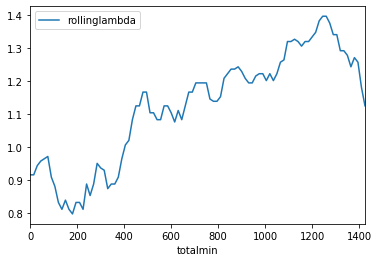

In [280]:
smooth[smooth.simgrouping == 'sgrp_222'][['totalmin','rollinglambda']].plot.line(x='totalmin',y='rollinglambda')

In [290]:
smooth

,simgrouping,totalmin,lambda_car,rollinglambda
0,group1,0,0.875000,0.875000
480,group6,0,1.333333,1.333333
864,sgrp_20,0,0.950000,0.950000
192,group3,0,1.117361,1.117361
96,group2,0,0.900000,0.900000
...,...,...,...,...
287,group3,1425,1.159028,1.171875
191,group2,1425,1.000000,0.950000
95,group1,1425,1.000000,1.062500
1247,sgrp_222,1425,1.000000,1.125000


In [296]:
thing = smooth.drop(['lambda_car'],axis=1).set_index('totalmin').groupby('simgrouping').apply(lambda s: s.to_dict(orient='index'))

In [315]:
import math
smooth.rollinglambda = smooth.rollinglambda.apply(lambda s: round(s,2))

In [317]:
lambdamap = dict()

for i in smooth['simgrouping'].unique():
    lambdamap[i] = smooth[smooth.simgrouping == i].set_index('totalmin')['rollinglambda'].to_dict()

In [323]:
nodelambdas = idgrp.set_index('node_id')['simgrouping'].to_dict()

In [326]:
for k in nodelambdas:
    nodelambdas[k] = lambdamap[nodelambdas[k]]

In [334]:
check = set(nodelambdas.keys())

In [333]:
cmp = set([i for i in DG.nodes if "source" in DG.nodes[i]["nodetype"]])

In [338]:
#nodelambdas

In [340]:
outp = r"/Users/hsajer3/NYU/bdad/BDAD_Violet_Noise/microsimulation/sumoDataGeneration/data/nodelambdas.json"

In [344]:
with open(outp,"w") as outs:
    outs.write(json.dumps(nodelambdas))

In [365]:
with open(outp, "r") as test:
    f = json.load(test)

In [361]:
f = {int(k):v for k, v in f.items()}

In [369]:
with open(file2,"r") as ins:
    f = json.load(ins)

In [371]:
stopmap

{'35to36': 'station0',
 '62to33': 'station1',
 '77to76': 'station2',
 '70to41': 'station3',
 '126to125': 'station4',
 '151to152': 'station5',
 '193to194': 'station6',
 '91to120': 'station7',
 '106to77': 'station8',
 '138to137': 'station9',
 '180to179': 'station10',
 '65to64': 'station11',
 '106to107': 'station12',
 '99to128': 'station13',
 '191to190': 'station14',
 '172to143': 'station15',
 '182to183': 'station16',
 '198to197': 'station17',
 '85to114': 'station18',
 '162to163': 'station19',
 '93to94': 'station20',
 '45to46': 'station21'}

In [372]:
for rec in f:
    rec['stops'] = [stopmap[i] for i in rec['stops']]

In [373]:
f

[{'busroute': '29|215',
  'active_hrs': [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22],
  'start_min': 11,
  'stops': ['station0', 'station13']},
 {'busroute': '29|230',
  'active_hrs': [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22],
  'start_min': 31,
  'stops': ['station0', 'station21', 'station18']},
 {'busroute': '29|57',
  'active_hrs': [4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22],
  'start_min': 51,
  'stops': ['station0', 'station21']},
 {'busroute': '87|12',
  'active_hrs': [0, 2, 4, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 19, 20, 22],
  'start_min': 6,
  'stops': ['station20', 'station3']},
 {'busroute': '87|27',
  'active_hrs': [0, 2, 4, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 19, 20, 22],
  'start_min': 26,
  'stops': ['station20', 'station12']},
 {'busroute': '87|115',
  'active_hrs': [0, 2, 4, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 19, 20, 22],
  'start_min': 46,
  'stops': ['station20', 'station12']},
 {'busroute': '145|173',
  'acti